# Integrantes del Grupo:
### José Luis Flores Tito
### Ariel Huarachi Clemente
### Shariel Aylin Verduguez Choquevillca
### Duran Chambi Benjamin Ricardo Duran



## CartPole con Gymnasiun

Episodio: 0  Recompensa: 18.0  Epsilon: 1.00  Recompensa media: 18.0
Episodio: 100  Recompensa: 13.0  Epsilon: 1.00  Recompensa media: 21.8
Episodio: 200  Recompensa: 28.0  Epsilon: 1.00  Recompensa media: 22.6
Episodio: 300  Recompensa: 17.0  Epsilon: 1.00  Recompensa media: 24.3
Episodio: 400  Recompensa: 23.0  Epsilon: 1.00  Recompensa media: 23.9
Episodio: 500  Recompensa: 12.0  Epsilon: 1.00  Recompensa media: 22.3
Episodio: 600  Recompensa: 38.0  Epsilon: 0.99  Recompensa media: 22.0
Episodio: 700  Recompensa: 11.0  Epsilon: 0.99  Recompensa media: 22.8
Episodio: 800  Recompensa: 17.0  Epsilon: 0.99  Recompensa media: 24.2
Episodio: 900  Recompensa: 15.0  Epsilon: 0.99  Recompensa media: 24.8
Episodio: 1000  Recompensa: 11.0  Epsilon: 0.99  Recompensa media: 22.0
Episodio: 1100  Recompensa: 22.0  Epsilon: 0.99  Recompensa media: 22.1
Episodio: 1200  Recompensa: 20.0  Epsilon: 0.99  Recompensa media: 23.9
Episodio: 1300  Recompensa: 12.0  Epsilon: 0.99  Recompensa media: 24.1
Epis

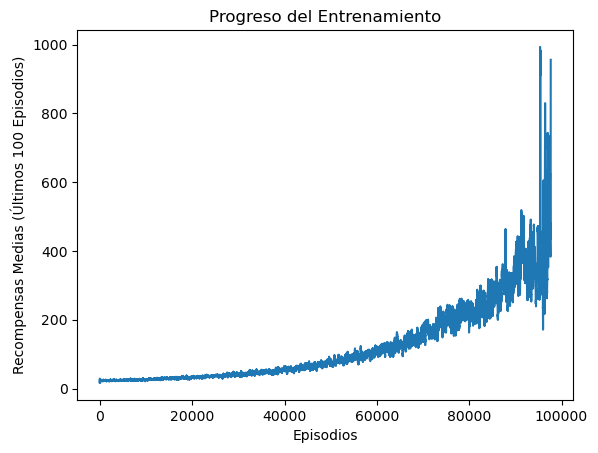

In [4]:
# ================================================
# Implementación de Q-Learning para el entorno CartPole-v1
# ================================================

# Importamos las librerías necesarias
import gymnasium as gym          # Entornos de simulación (CartPole, MountainCar, etc.)
import numpy as np               # Cálculos numéricos y manejo de arrays
import matplotlib.pyplot as plt  # Gráficas de progreso
import pickle                    # Guardar/cargar el modelo entrenado (tabla Q)

# ------------------------------------------------
# Función principal: entrena o ejecuta el agente
# ------------------------------------------------
def run(is_training=True, render=False):

    # Crear el entorno de CartPole
    # render_mode='human' muestra la simulación si render=True
    env = gym.make('CartPole-v1', render_mode='human' if render else None)

    # ------------------------------------------------
    # Discretización del espacio de estados
    # ------------------------------------------------
    # El entorno CartPole tiene 4 variables continuas:
    # 1. posición del carro
    # 2. velocidad del carro
    # 3. ángulo de la vara
    # 4. velocidad angular de la vara
    #
    # Aquí se dividen esos rangos en 10 segmentos para discretizarlos.
    pos_space = np.linspace(-2.4, 2.4, 10)
    vel_space = np.linspace(-4, 4, 10)
    ang_space = np.linspace(-.2095, .2095, 10)
    ang_vel_space = np.linspace(-4, 4, 10)

    # ------------------------------------------------
    # Inicialización o carga de la tabla Q
    # ------------------------------------------------
    if is_training:
        # Si estamos entrenando, inicializamos la tabla Q con ceros
        # La tabla tiene dimensiones [pos][vel][ang][ang_vel][acción]
        # 11x11x11x11x2 porque cada espacio tiene 10 divisiones + 1, y hay 2 acciones (izquierda/derecha)
        q = np.zeros((len(pos_space)+1,
                      len(vel_space)+1,
                      len(ang_space)+1,
                      len(ang_vel_space)+1,
                      env.action_space.n))
    else:
        # Si no estamos entrenando, cargamos la tabla Q desde un archivo previamente guardado
        f = open('cartpole.pkl', 'rb')
        q = pickle.load(f)
        f.close()

    # ------------------------------------------------
    # Hiperparámetros del algoritmo Q-Learning
    # ------------------------------------------------
    learning_rate_a = 0.3          # α (alpha): tasa de aprendizaje
    discount_factor_g = 0.99       # γ (gamma): factor de descuento
    epsilon = 1                    # Probabilidad inicial de elegir una acción aleatoria (exploración)
    epsilon_decay_rate = 0.00001   # Tasa de decrecimiento de epsilon
    rng = np.random.default_rng()  # Generador de números aleatorios

    # Lista para guardar las recompensas por episodio
    rewards_per_episode = []

    # Contador de episodios
    i = 0

    # ------------------------------------------------
    # Bucle principal de episodios
    # ------------------------------------------------
    while(True):

        # Reiniciamos el entorno y obtenemos el estado inicial
        state = env.reset()[0]

        # Convertimos cada variable continua en un índice discreto (bin)
        state_p = np.digitize(state[0], pos_space)   # posición
        state_v = np.digitize(state[1], vel_space)   # velocidad
        state_a = np.digitize(state[2], ang_space)   # ángulo
        state_av = np.digitize(state[3], ang_vel_space)  # velocidad angular

        # Variable para indicar si el episodio terminó
        terminated = False

        # Recompensa acumulada en este episodio
        rewards = 0

        # ------------------------------------------------
        # Bucle interno: pasos dentro de un episodio
        # ------------------------------------------------
        while(not terminated and rewards < 10000):

            # Política ε-greedy:
            # Con probabilidad epsilon elige acción aleatoria (explorar)
            # Si no, elige la mejor acción conocida (explotar)
            if is_training and rng.random() < epsilon:
                action = env.action_space.sample()  # acción aleatoria
            else:
                action = np.argmax(q[state_p, state_v, state_a, state_av, :])  # mejor acción conocida

            # Ejecutamos la acción en el entorno
            new_state, reward, terminated, _, _ = env.step(action)

            # Discretizamos el nuevo estado
            new_state_p = np.digitize(new_state[0], pos_space)
            new_state_v = np.digitize(new_state[1], vel_space)
            new_state_a = np.digitize(new_state[2], ang_space)
            new_state_av = np.digitize(new_state[3], ang_vel_space)

            # ------------------------------------------------
            # Actualización de la tabla Q (solo si estamos entrenando)
            # ------------------------------------------------
            if is_training:
                q[state_p, state_v, state_a, state_av, action] += learning_rate_a * (
                    reward + discount_factor_g * np.max(q[new_state_p, new_state_v, new_state_a, new_state_av, :])
                    - q[state_p, state_v, state_a, state_av, action]
                )

            # Actualizamos el estado actual con el nuevo
            state = new_state
            state_p = new_state_p
            state_v = new_state_v
            state_a = new_state_a
            state_av = new_state_av

            # Acumulamos la recompensa
            rewards += reward

            # Si estamos solo ejecutando (no entrenando), mostramos progreso
            if not is_training and rewards % 100 == 0:
                print(f'Episodio: {i}  Recompensas: {rewards}')

        # ------------------------------------------------
        # Fin del episodio
        # ------------------------------------------------
        # Guardamos la recompensa total obtenida
        rewards_per_episode.append(rewards)

        # Calculamos el promedio de recompensas de los últimos 100 episodios
        mean_rewards = np.mean(rewards_per_episode[max(0, len(rewards_per_episode)-100):])

        # Imprimimos el progreso durante el entrenamiento
        if is_training and i % 100 == 0:
            print(f'Episodio: {i}  Recompensa: {rewards}  Epsilon: {epsilon:0.2f}  Recompensa media: {mean_rewards:0.1f}')

        # Si el agente ya logra mantener el palo más de 1000 pasos de media → se detiene el entrenamiento
        if mean_rewards > 1000:
            break

        # Disminuimos epsilon (menos exploración, más explotación)
        epsilon = max(epsilon - epsilon_decay_rate, 0)

        # Aumentamos el contador de episodios
        i += 1

    # Cerramos el entorno al finalizar
    env.close()

    # ------------------------------------------------
    # Guardar la tabla Q entrenada
    # ------------------------------------------------
    if is_training:
        f = open('cartpole.pkl', 'wb')
        pickle.dump(q, f)
        f.close()

    # ------------------------------------------------
    # Generar gráfica de progreso
    # ------------------------------------------------
    mean_rewards = []
    for t in range(i):
        # Calcula la media móvil de las últimas 100 recompensas
        mean_rewards.append(np.mean(rewards_per_episode[max(0, t-100):(t+1)]))

    # Crear el gráfico
    plt.plot(mean_rewards)
    plt.xlabel('Episodios')  
    plt.ylabel('Recompensas Medias (Últimos 100 Episodios)')  
    plt.title('Progreso del Entrenamiento')  
    plt.savefig('cartpole.png')  # Guarda la imagen con los resultados

# ------------------------------------------------
# Ejecución del programa
# ------------------------------------------------
if __name__ == '__main__':
    # Entrenamiento del agente
    run(is_training=True, render=False)



## Ejecutamos el agente entrenado

Episodio: 0  Recompensas: 100.0
Episodio: 0  Recompensas: 200.0
Episodio: 0  Recompensas: 300.0
Episodio: 0  Recompensas: 400.0
Episodio: 0  Recompensas: 500.0
Episodio: 0  Recompensas: 600.0
Episodio: 0  Recompensas: 700.0
Episodio: 0  Recompensas: 800.0
Episodio: 0  Recompensas: 900.0
Episodio: 0  Recompensas: 1000.0
Episodio: 0  Recompensas: 1100.0
Episodio: 0  Recompensas: 1200.0
Episodio: 0  Recompensas: 1300.0
Episodio: 0  Recompensas: 1400.0
Episodio: 0  Recompensas: 1500.0
Episodio: 0  Recompensas: 1600.0
Episodio: 0  Recompensas: 1700.0
Episodio: 0  Recompensas: 1800.0
Episodio: 0  Recompensas: 1900.0
Episodio: 0  Recompensas: 2000.0
Episodio: 0  Recompensas: 2100.0
Episodio: 0  Recompensas: 2200.0
Episodio: 0  Recompensas: 2300.0
Episodio: 0  Recompensas: 2400.0
Episodio: 0  Recompensas: 2500.0
Episodio: 0  Recompensas: 2600.0
Episodio: 0  Recompensas: 2700.0
Episodio: 0  Recompensas: 2800.0
Episodio: 0  Recompensas: 2900.0
Episodio: 0  Recompensas: 3000.0
Episodio: 0  Recomp

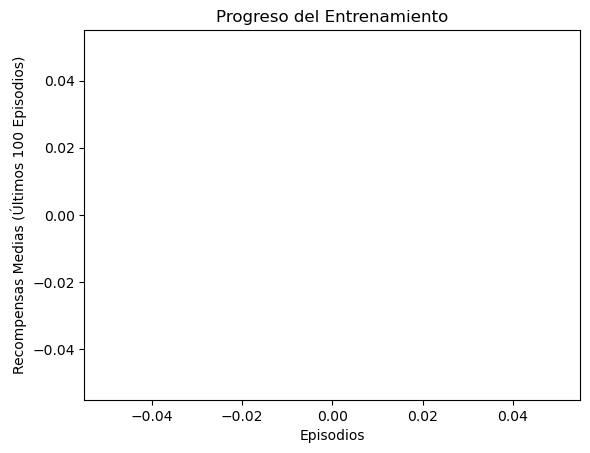

In [5]:
if __name__ == '__main__':

    run(is_training=False, render=True)